In [1]:
import shap
import pickle
import matplotlib.pyplot as plt
import numpy as np

/Users/clawsy/Documents/GitHub/xai-classification/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load data.pkl
with open('data/data_c.pkl', 'rb') as file:
    data = pickle.load(file)
# load model.pkl
with open('xgb_models/opt_XGB_C.pkl', 'rb') as file:
    xgb = pickle.load(file)

In [3]:
print("Model C")
# Print the accuracy of training
print("Training Accuracy: %.2f%%" %(xgb.score(data['X_train'], data['y_train'].values)*100))
# Print the accuracy of validation
print("Validation Accuracy: %.2f%%" %(xgb.score(data['X_val'], data['y_val'].values)*100))
# Print the accuracy of testing
print("Testing Accuracy: %.2f%%" %(xgb.score(data['X_test'], data['y_test'].values)*100))

Model C
Training Accuracy: 98.33%
Validation Accuracy: 88.04%
Testing Accuracy: 85.54%


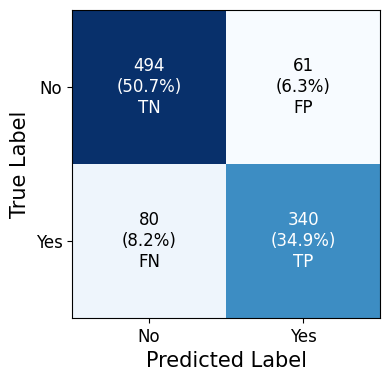

In [4]:
from sklearn.metrics import confusion_matrix
# Define the figure size
plt.figure(figsize=(6, 4))

# Define the true labels and predicted labels for model3
y_true = data['y_test']
y_pred = xgb.predict(data['X_test'])

# Compute the confusion matrix
cm_model = confusion_matrix(y_true.values, y_pred)

# Define the class names
class_names = ['No', 'Yes']

# Plot the confusion matrix for model3
plt.imshow(cm_model, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('')
#plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, fontsize=12)  # Increase font size
plt.yticks(tick_marks, class_names, fontsize=12)  # Increase font size
plt.xlabel('Predicted Label', fontsize=15)  # Increase font size
plt.ylabel('True Label', fontsize=15)  # Increase font size
nl = '\n'
# Add the values to the confusion matrix plot
cell_text = np.array([['TN', 'FP'], ['FN', 'TP']])
thresh_model3 = cm_model.max() / 2.
for i in range(cm_model.shape[0]):
    for j in range(cm_model.shape[1]):
        plt.text(j, i, f'{cm_model[i, j]:d}{nl}({cm_model[i, j]/len(y_true)*100.0:.1f}%){nl}{cell_text[i,j]}',
                 horizontalalignment="center", verticalalignment="center",
                 color="white" if cm_model[i, j] > thresh_model3 else "black",
                 fontsize=12)  # Increase font size
# plt.savefig('figs/cm_modela.eps', format='eps', dpi=300, bbox_inches='tight')

In [5]:
pred_probs_test = xgb.predict_proba(data['X_test'])[:, 1]
pred_test = xgb.predict(data['X_test'])
tp_test = (pred_test == data['y_test']) & (data['y_test'] == 1)
tn_test = (pred_test == data['y_test']) & (data['y_test'] == 0)
fp_test = (pred_test != data['y_test']) & (data['y_test'] == 0)
fn_test = (pred_test != data['y_test']) & (data['y_test'] == 1)

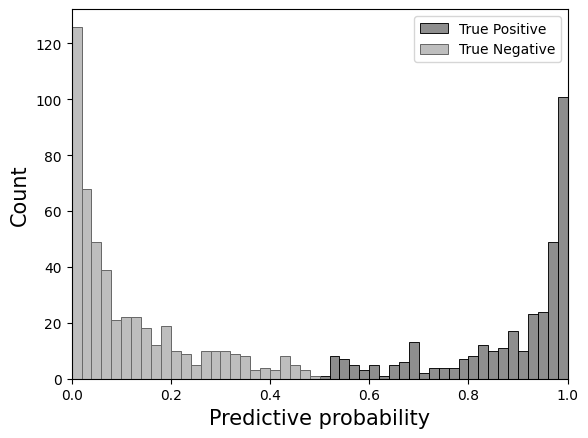

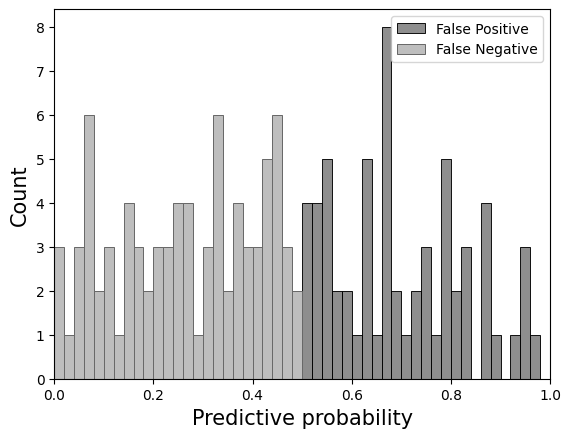

In [6]:
import seaborn as sns
def pred_prob(data1, data2=None, labels=None):
    sns.histplot(data1, 
                    bins= np.linspace(0,1,51), color = 'dimgray', 
                    edgecolor='k',stat='count').set(xlim=(0,1))
    sns.histplot(data2, 
                    bins= np.linspace(0,1,51), color = 'darkgray', 
                    edgecolor='dimgray',stat='count').set(xlim=(0,1))
    if labels is not None:
        plt.legend(labels)

    plt.xlabel('Predictive probability', fontsize=15)
    plt.ylabel('Count', fontsize=15)

pred_prob(data1=pred_probs_test[tp_test], data2=pred_probs_test[tn_test], labels=['True Positive', 'True Negative'])
# plt.savefig('figs/pred_probs_tntp.eps', format='eps', dpi=300, bbox_inches='tight')
plt.show()
pred_prob(data1=pred_probs_test[fp_test], data2=pred_probs_test[fn_test], labels=['False Positive','False Negative'])
# plt.savefig('figs/pred_probs_fnfp.eps', format='eps', dpi=300, bbox_inches='tight')
plt.show()

In [7]:
# Create an explainer for Model C
explainer = shap.Explainer(xgb)
# Generate SHAP values for Model C
shap_values = explainer(data['X_all'])

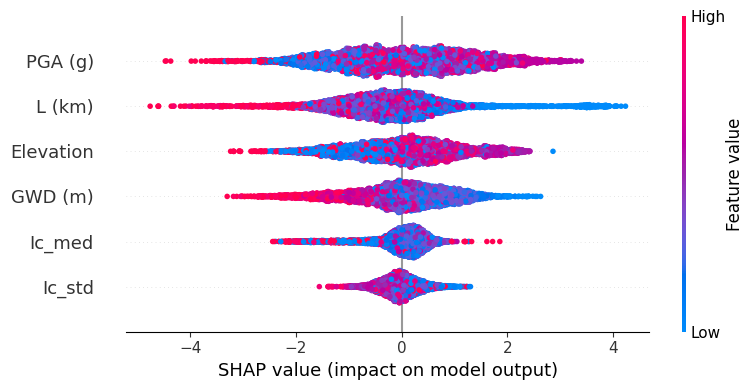

In [8]:
# Plot the SHAP summary plot for Model C
shap.summary_plot(shap_values, data['X_all'],plot_size=(8,4), show=False)
# plt.savefig('figs/shap_summary_modela.eps', format='eps', dpi=300, bbox_inches='tight')
plt.show()

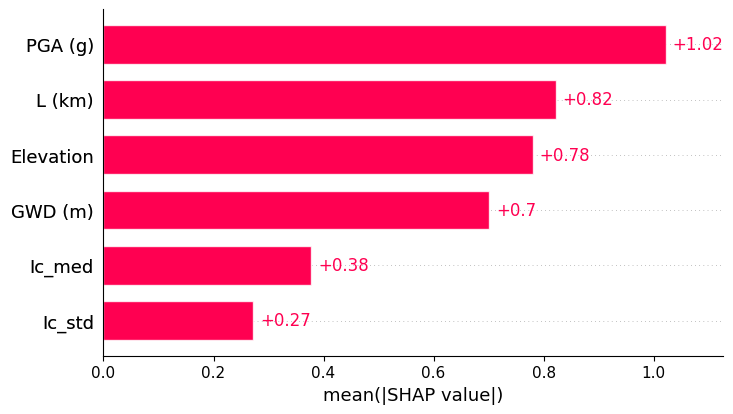

In [9]:
plt.figure(figsize=(12, 8))
shap.plots.bar(shap_values, show=False)
# plt.savefig('figs/shap_bar_modela.eps', format='eps', dpi=300, bbox_inches='tight')
plt.show()

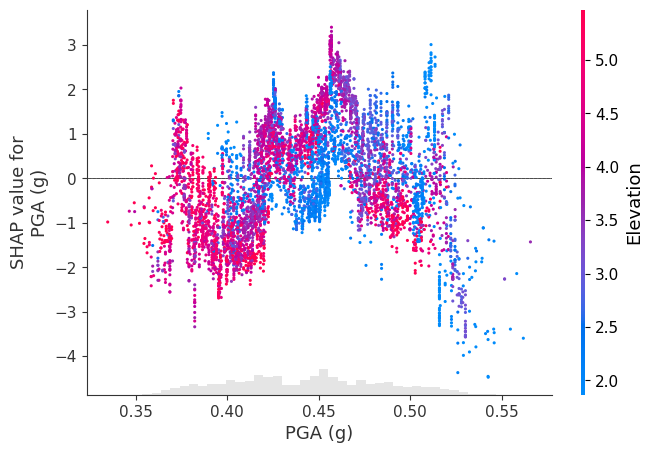

In [10]:
shap.plots.scatter(shap_values=shap_values[:,'PGA (g)'], color=shap_values[:, 'Elevation'], dot_size=5,show=False)
plt.axhline(0, color='k', linewidth=0.5, zorder=-10)
# plt.savefig('figs/shap_scatter_modela.eps', format='eps', dpi=300, bbox_inches='tight')
plt.show()

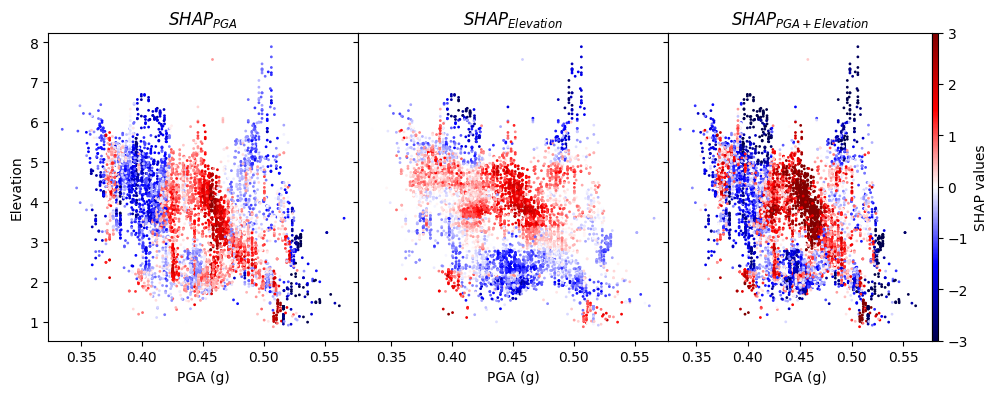

In [11]:
feature_x = 'PGA (g)'
feature_y = 'Elevation'
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(12, 4))
gs = gridspec.GridSpec(1, 3, wspace=0)

ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1])
ax2 = fig.add_subplot(gs[2])

combine_shap = shap_values[:, feature_x].values + shap_values[:, feature_y].values
ax0.scatter(shap_values[:, feature_x].data, y=shap_values[:, feature_y].data, c=shap_values[:, feature_x].values, cmap='seismic', s=1, vmin=-3, vmax=3)
ax1.scatter(shap_values[:, feature_x].data, y=shap_values[:, feature_y].data, c=shap_values[:, feature_y].values, cmap='seismic', s=1, vmin=-3, vmax=3)
subplot2 = ax2.scatter(shap_values[:, feature_x].data, y=shap_values[:, feature_y].data, c=combine_shap, cmap='seismic', s=1, vmin=-3, vmax=3)

plt.colorbar(mappable=subplot2, ax=ax2, label='SHAP values', pad=0, aspect=50)

ax0.set_title('$SHAP_{PGA}$')
ax1.set_title('$SHAP_{Elevation}$')
ax2.set_title('$SHAP_{PGA+Elevation}$')
ax0.set_xlabel(feature_x)
ax1.set_xlabel(feature_x)
ax2.set_xlabel(feature_x)
ax1.set_yticklabels([])
ax2.set_yticklabels([])
ax0.set_ylabel(feature_y)

plt.show()

See what Model C has learned without qc1ncs feature

In [12]:
# load qc1ncs data from data_b.pkl
with open('data/data_b.pkl', 'rb') as file:
    data_b = pickle.load(file)
qc1ncs = data_b['X_all']['qc1Ncs_med'].values

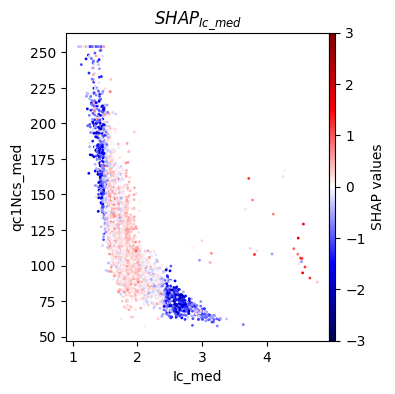

In [13]:
feature_x = 'Ic_med'
feature_y = 'qc1Ncs_med'

fig, ax = plt.subplots(figsize=(4, 4))

subplot = ax.scatter(shap_values[:, feature_x].data, y=qc1ncs, c=shap_values[:, feature_x].values, cmap='seismic', s=1, vmin=-3, vmax=3)
plt.colorbar(mappable=subplot, ax=ax, label='SHAP values', pad=0, aspect=50)

ax.set_title('$SHAP_{Ic\_med}$')
ax.set_xlabel(feature_x)
ax.set_ylabel(feature_y)

plt.show()

In [14]:
predictions = xgb.predict(data['X_all'])
pred_probs = xgb.predict_proba(data['X_all'])[:, 1]

Find local explanation with Test ID

Predicted Probability: 98.84%


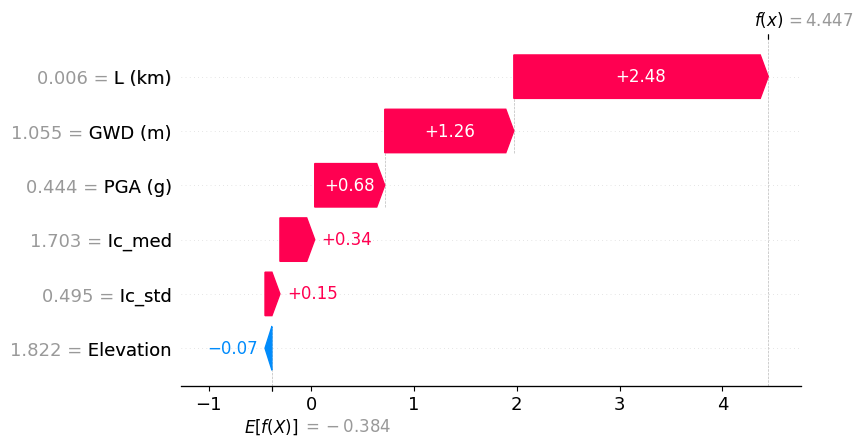

In [15]:
find_id = 1138
index = np.where(data['X']['Test ID'] == find_id)[0][0]
shap.plots.waterfall(shap_values[index],show=False)
print(f'Predicted Probability: {pred_probs[index]*100:.2f}%')
plt.show()

Find local explanation using prediction categories

In [16]:
observed = data['y'].values
tp = (predictions == observed) & (observed == 1)
tn = (predictions == observed) & (observed == 0)
fp = (predictions != observed) & (observed == 0)
fn = (predictions != observed) & (observed == 1)

Predicted Probability: 2.53%


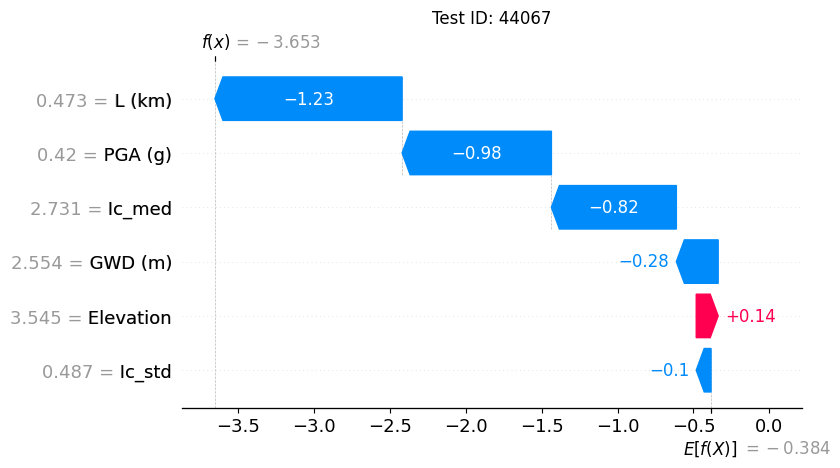

In [17]:
mask = tn # Change this to tp, tn, fp, or fn
index = np.random.randint(0, sum(mask)-1)
shap.plots.waterfall(shap_values[mask][index],show=False)
print(f'Predicted Probability: {pred_probs[mask][index]*100:.2f}%')
find_id = data['X']['Test ID'][mask].iloc[index]
plt.title(f'Test ID: {find_id:0.0f}')
plt.show()